所有文件已生成！


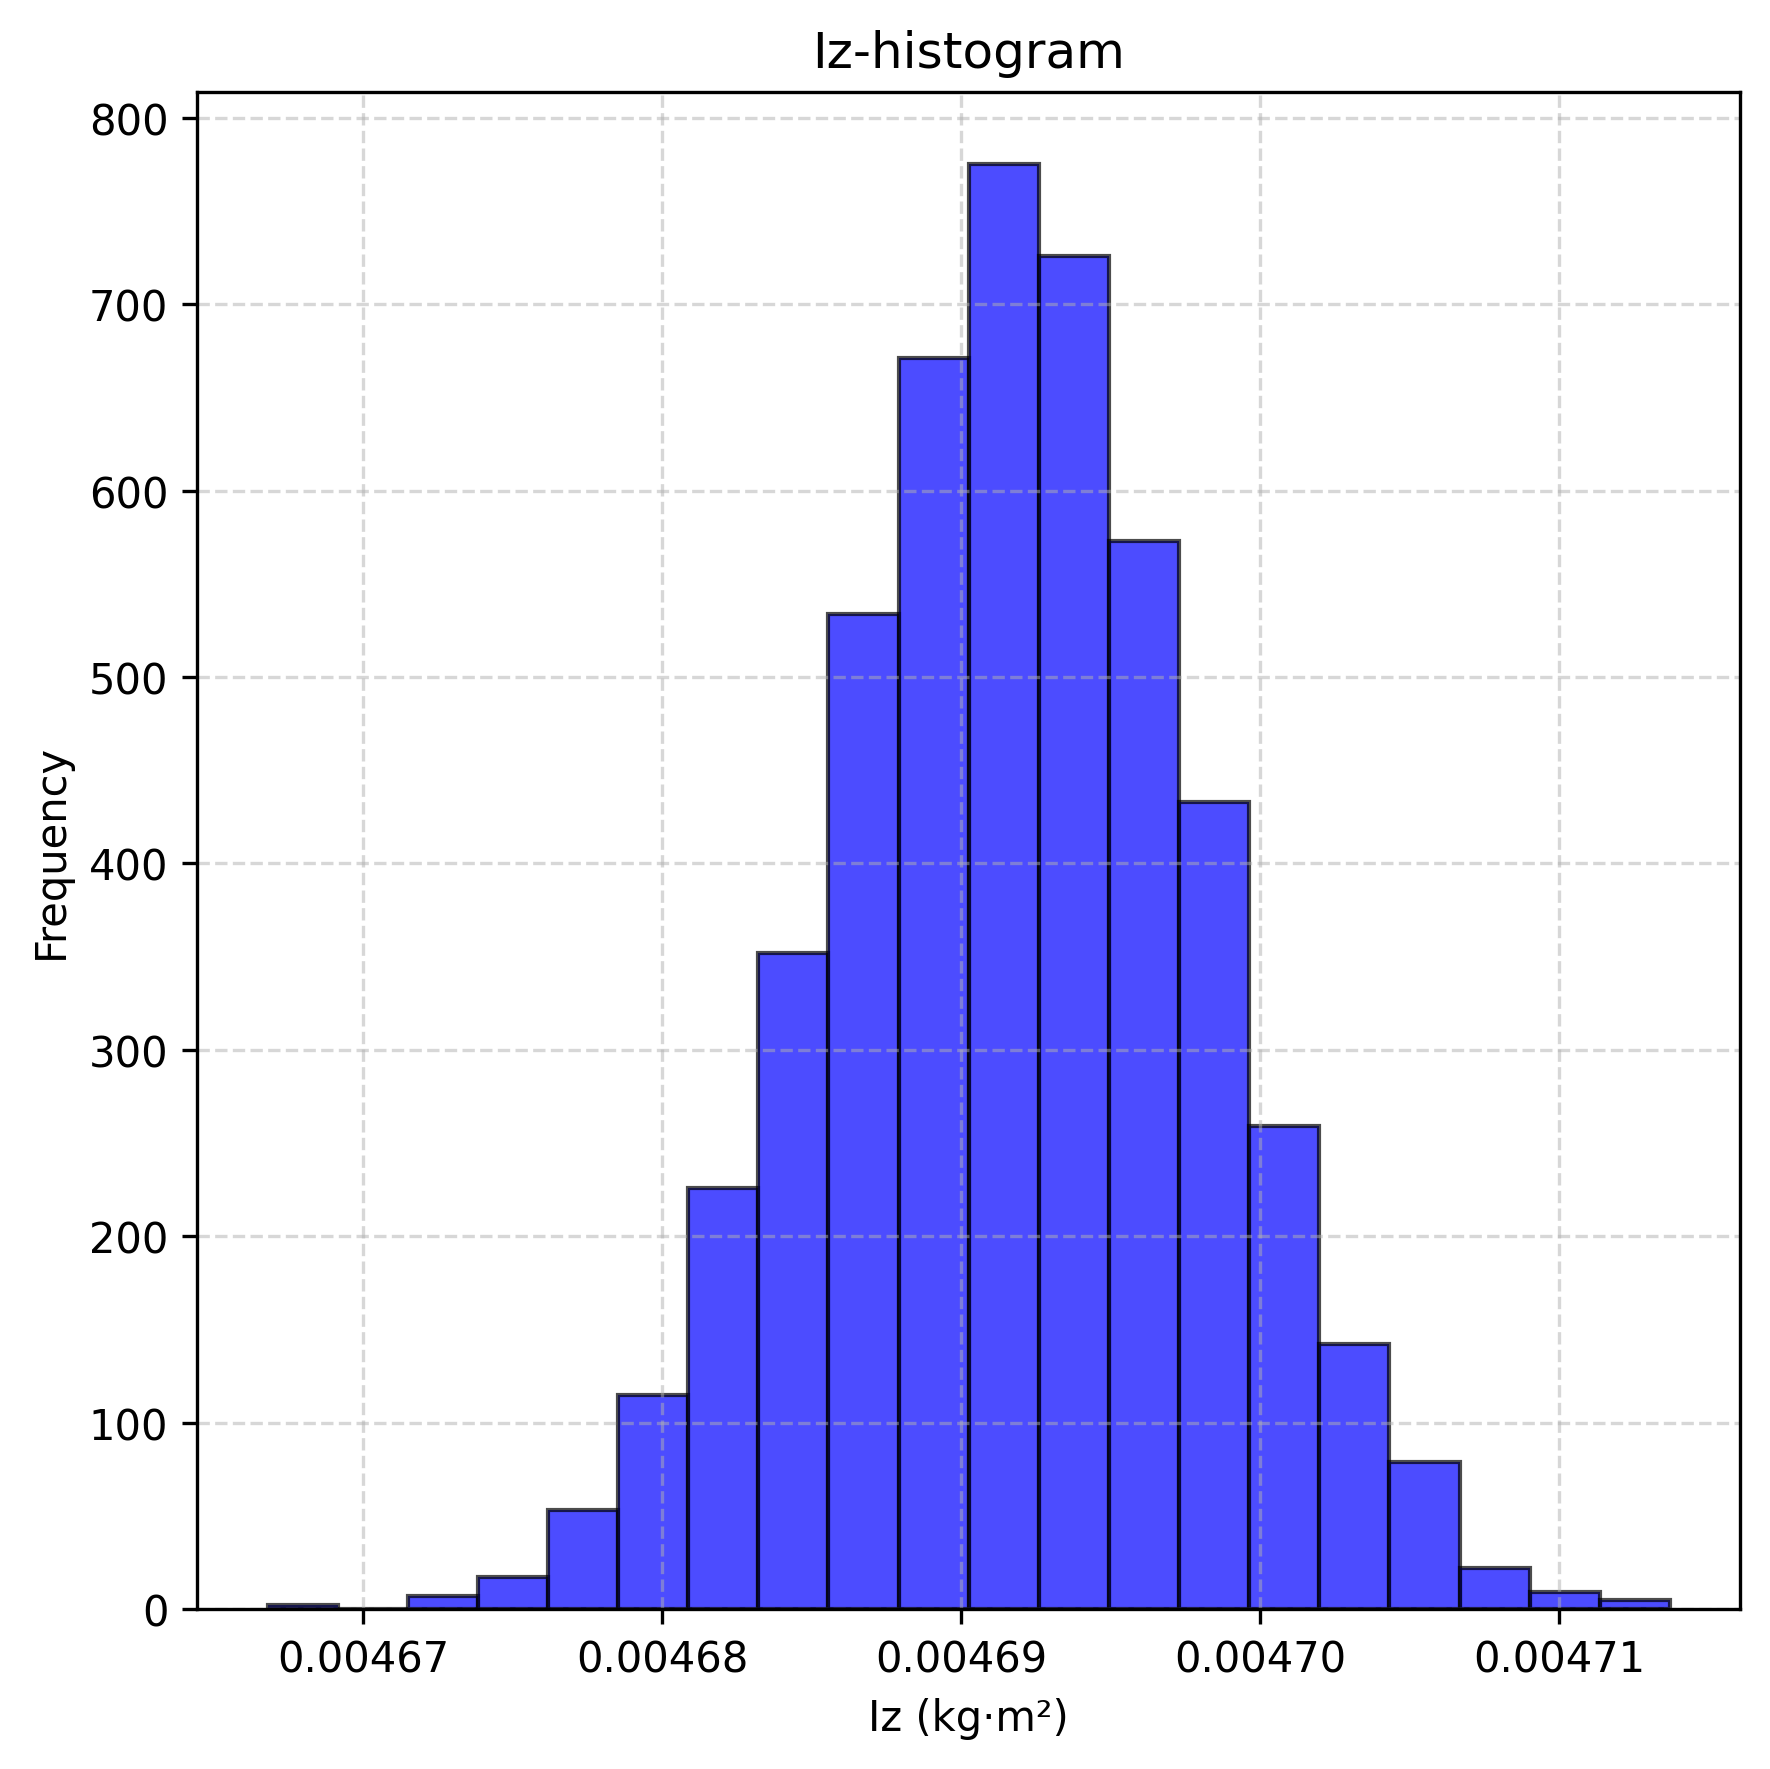

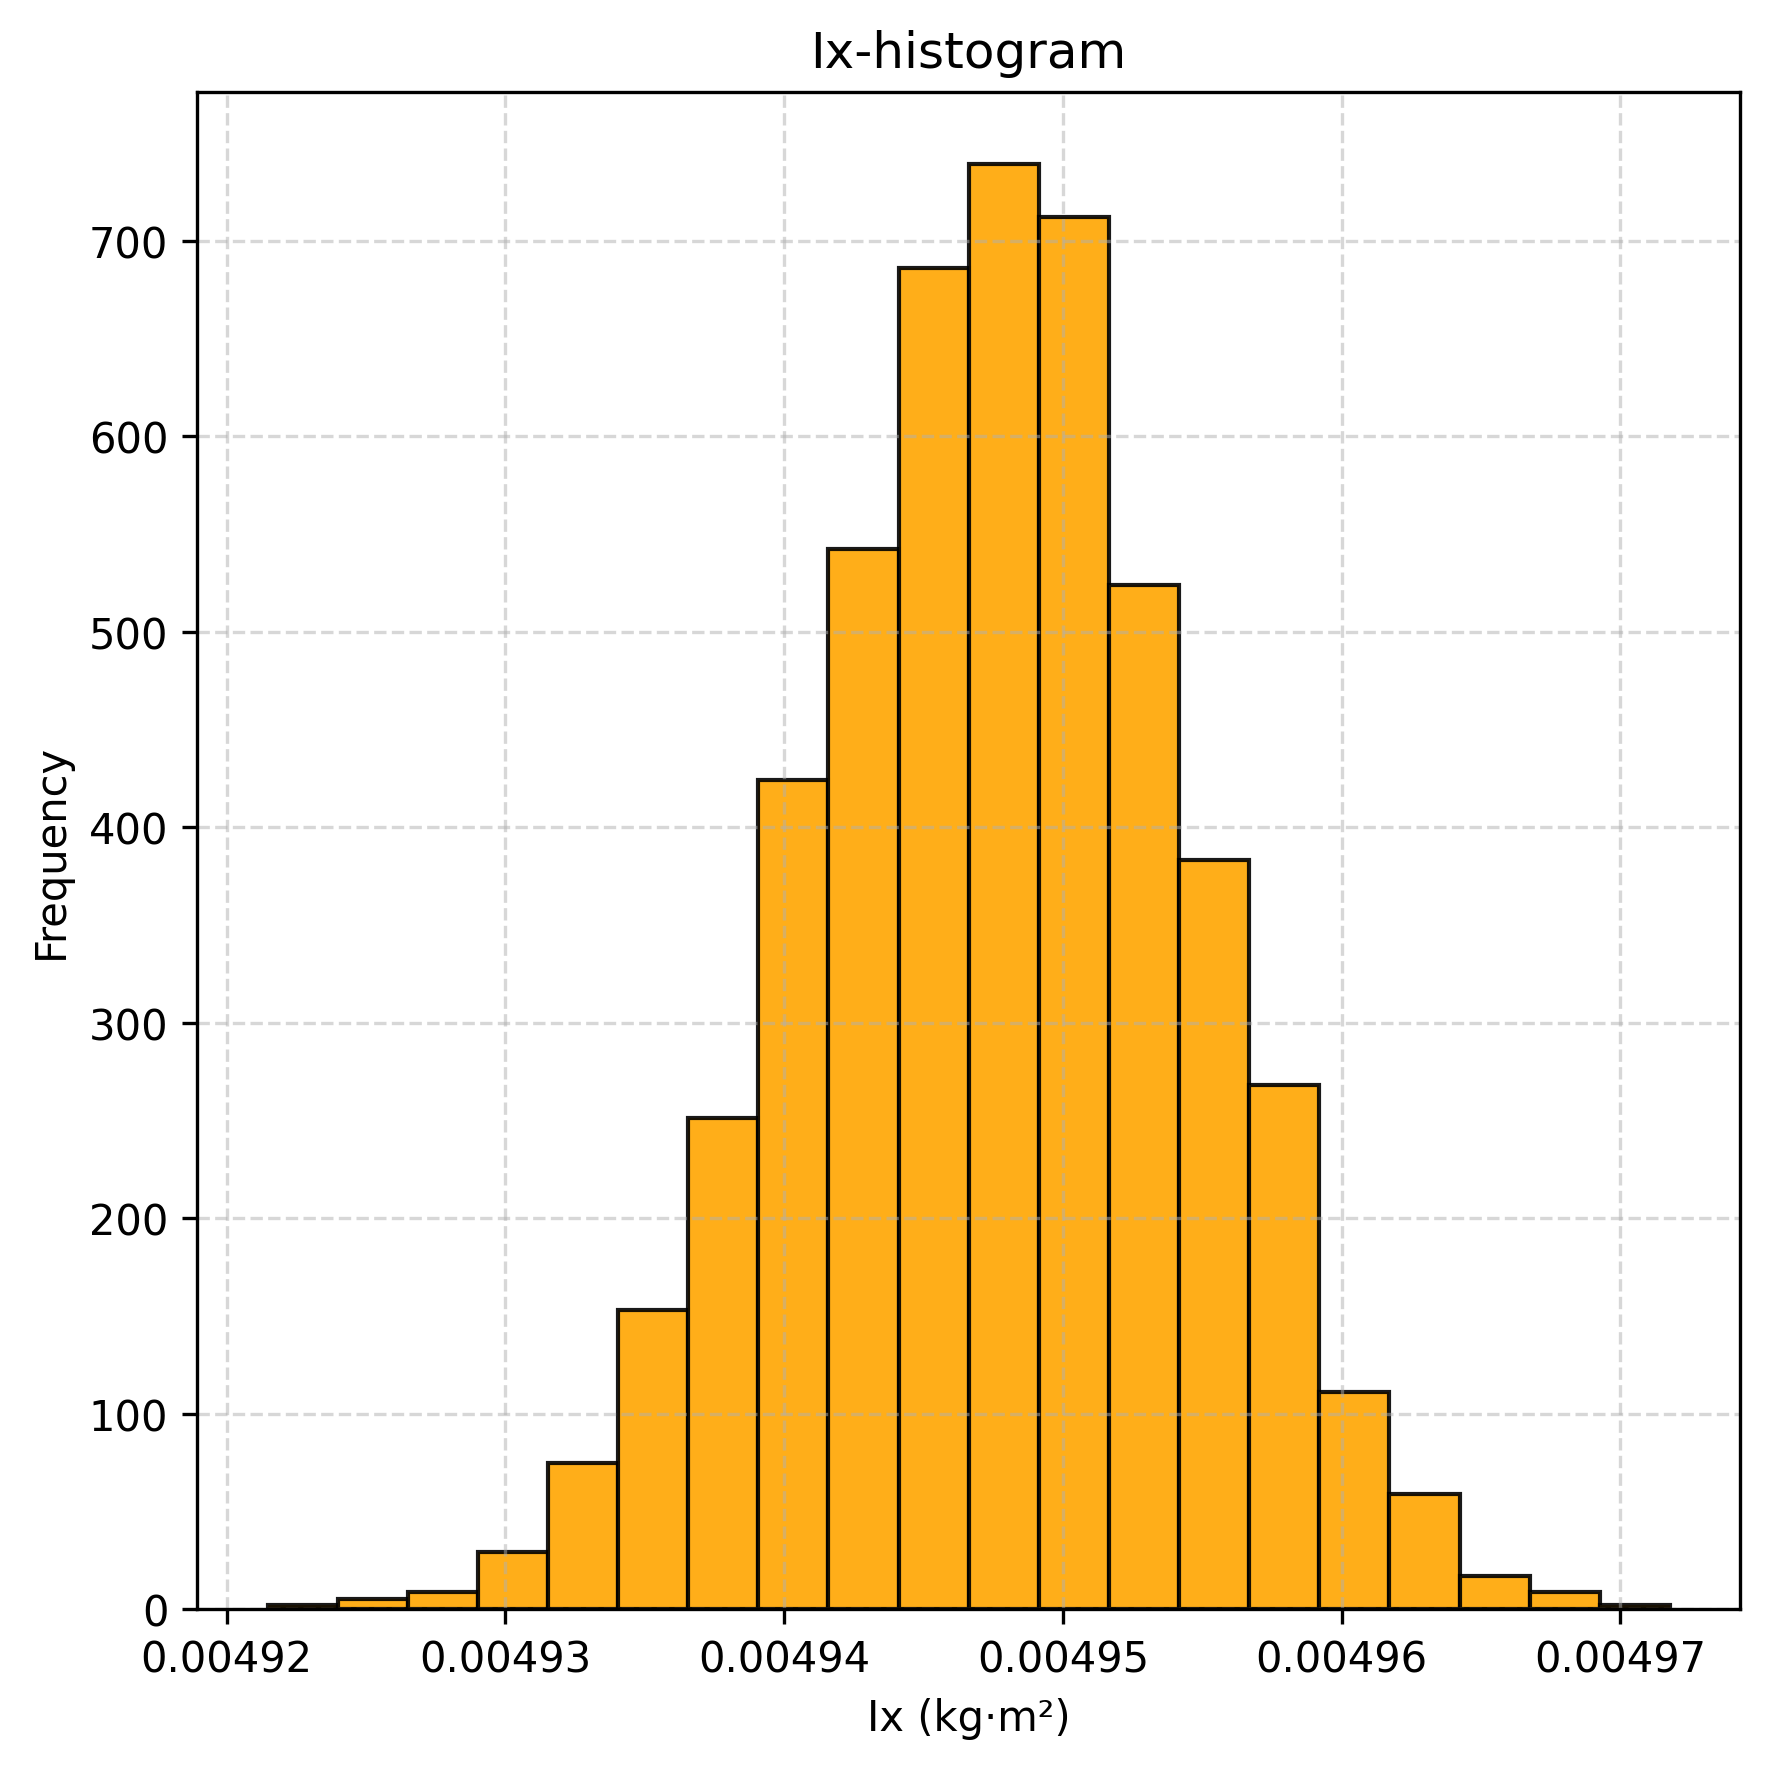

In [6]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from numba import jit  # 用于加速Python函数
import re  # 正则表达式库，用于文本处理

# 使用numba的jit加速装饰器，提升计算性能
@jit(nopython=True)
def I_z(npt, r1, r2, rho1, rho2):
    """计算绕Z轴的转动惯量（蒙特卡洛方法）"""
    total = 0
    for _ in range(npt):
        # 在立方体范围内生成随机点
        x = np.random.uniform(-r1, r1)
        y = np.random.uniform(-r1, r1)
        z = np.random.uniform(-r1, r1)
        # 判断点是否在球体内且在圆柱体内
        if x*x + y*y + z*z <= r1*r1 and x*x + y*y <= r2*r2:
            total += rho2 * (x*x + y*y)  # 圆柱区域使用rho2密度
        elif x*x + y*y + z*z <= r1*r1:
            total += rho1 * (x*x + y*y)  # 球体非圆柱区域使用rho1密度
    # 计算积分结果（体积乘以平均值）
    return (2*r1)**3 * total / npt

@jit(nopython=True)
def I_x(npt, r1, r2, rho1, rho2):
    """计算绕X轴的转动惯量（蒙特卡洛方法）"""
    total = 0
    for _ in range(npt):
        x = np.random.uniform(-r1, r1)
        y = np.random.uniform(-r1, r1)
        z = np.random.uniform(-r1, r1)
        if x*x + y*y + z*z <= r1*r1 and x*x + y*y <= r2*r2:
            total += rho2 * (y*y + z*z)  # 注意绕X轴时的分量计算
        elif x*x + y*y + z*z <= r1*r1:
            total += rho1 * (y*y + z*z)
    return (2*r1)**3 * total / npt

# 从输入文件读取参数
params = {}
with open("read.in", "r") as f:
    for line in f:
        line = line.strip()  # 去除首尾空白
        if line:  # 跳过空行
            # 分割键值对（以第一个等号为分隔符）
            key, value = line.split("=", 1)
            key = key.strip()
            params[key] = value.strip()
            # 特殊处理nbi参数为整数列表
            if key == "nbi":
                params["nbi"] = list(map(int, value.strip().split()))

# 参数类型转换
r1 = float(params["r1"])         # 半径r1
r2 = float(params["r2"])         # 半径r2
rho1 = float(params["rho1"])     # 密度1
rho2 = float(params["rho2"])     # 密度2
npt = int(params["npt"])         # 蒙特卡洛采样点数
nbi = np.array(params["nbi"])    # 不同迭代次数列表

# 主计算循环：对每个nbi值生成结果文件
for i in nbi:
    # 定义输出文件名
    bin_file = f"bin_{i}.dat"  # 原始数据文件
    res_file = f"res_{i}.dat"  # 统计结果文件
    
    total_z = 0       # 累计Iz值
    total_z_sq = 0    # 累计Iz平方值（用于计算方差）
    total_x = 0       # 累计Ix值
    total_x_sq = 0    # 累计Ix平方值
    
    # 写入原始数据文件
    with open(bin_file, "w", encoding="utf-8") as file:
        # 写入表头（注意对齐格式）
        header = (
            f"Number: {'Num':>5s} | "
            f"{'I_z_val(kg*m2)':>25s} | "
            f"{'I_x_val(kg*m2)':>25s}\n"
        )
        file.write(header)
        
        # 进行i次独立计算
        for num in range(i):
            I_z_val = I_z(npt, r1, r2, rho1, rho2)
            I_x_val = I_x(npt, r1, r2, rho1, rho2)
            
            # 累加统计量
            total_z += I_z_val
            total_x += I_x_val
            total_z_sq += I_z_val * I_z_val
            total_x_sq += I_x_val * I_x_val
            
            # 格式化写入数据行
            line = f"Number: {num+1:5d} | {I_z_val:25.18f} | {I_x_val:25.18f}\n"
            file.write(line)
    
    # 写入统计结果文件
    with open(res_file, "w", encoding="utf-8") as file:
        # 计算平均值和方差
        I_z_avg = total_z / i
        I_x_avg = total_x / i
        error_z = np.sqrt(total_z_sq/i - I_z_avg**2)  # 标准误差计算
        error_x = np.sqrt(total_x_sq/i - I_x_avg**2)
        
        # 写入结果
        file.write(f"Iz的平均值: {I_z_avg}\n")
        file.write(f"Ix的平均值: {I_x_avg}\n")
        file.write(f"Iz的标准误差: {error_z}\n")
        file.write(f"Ix的标准误差: {error_x}")

print("所有文件已生成！")

def read_data(file_path):
    """从数据文件中读取Iz和Ix的值"""
    i_z_values = []
    i_x_values = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        next(file)  # 跳过表头行
        
        for line_num, line in enumerate(file, 1):  # 从第2行开始
            line = line.strip()
            # 使用正则表达式分割竖线（处理可能存在的空格）
            parts = re.split(r'\s*\|\s*', line)
            
            try:
                # 提取数值并转换类型
                i_z = float(parts[1].strip())
                i_x = float(parts[2].strip())
                i_z_values.append(i_z)
                i_x_values.append(i_x)
            except ValueError as e:
                print(f"第 {line_num} 行数值转换失败: {str(e)}")
                continue
                
    return i_z_values, i_x_values

# 可视化结果
input_file = "bin_5000.dat"  # 示例数据文件
z_data, x_data = read_data(input_file)

# 绘制Iz直方图
plt.figure(figsize=(6, 6), dpi=300)
plt.hist(z_data, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Iz-histogram')
plt.xlabel('Iz (kg·m²)')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 绘制Ix直方图
plt.figure(figsize=(6, 6), dpi=300)
plt.hist(x_data, bins=20, color='orange', alpha=0.9, edgecolor='black')
plt.title('Ix-histogram')
plt.xlabel('Ix (kg·m²)')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()